In [ ]:
%%capture
# If getting 'Could not find project LASR_probe_gen' get key from https://wandb.ai/authorize and paste below
import wandb
wandb.login(key="")

# Do probe training

Load the activations and labels from HF, aggregate, and construct datasets to train the probe on (note sklearn doesn't require a validation dataset). Create a probe and fit it.

In [ ]:
import probe_gen.probes as probes
from sklearn.metrics import classification_report
from probe_gen.config import ConfigDict

# Load the best hyperparameters or set your own
probe_type = ["mean_torch", "attention_torch"][1]
dataset_name = "refusal_llama_3b_5k"
cfg = ConfigDict.from_json(probe_type, dataset_name)
# cfg = ConfigDict(layer=12, use_bias=True, normalize=True, lr=0.0001, weight_decay=0.0)

# Create train, val, and test datasets
activations_tensor, attention_mask, labels_tensor = probes.load_hf_activations_and_labels_at_layer(dataset_name, layer=cfg.layer, verbose=True)
if probe_type == "mean_torch":
    activations_tensor = probes.MeanAggregation()(activations_tensor, attention_mask)
train_dataset, val_dataset, test_dataset = probes.create_activation_datasets(activations_tensor, labels_tensor, splits=[3500, 500, 0], verbose=True)

# Initialise and fit a probe with the datasets
if probe_type == "mean_torch":
    probe = probes.TorchLinearProbe(cfg)
elif probe_type == "attention_torch":
    probe = probes.TorchAttentionProbe(cfg)
probe.fit(train_dataset, val_dataset)

# Print val results
eval_dict, y_pred, y_pred_proba = probe.eval(val_dataset)
print('\nroc_auc:', eval_dict['roc_auc'])

Evaluate the probe on test dataset.

In [ ]:
# Eval against seperate test datasets
for new_dataset_name in ["refusal_llama_3b_1k", "refusal_llama_3b_prompted_1k", "refusal_ministral_8b_1k"]:
    print(f"\nEvaluating on {new_dataset_name}")
    activations_tensor, attention_mask, labels_tensor = probes.load_hf_activations_and_labels_at_layer(new_dataset_name, layer=cfg.layer, verbose=True)
    if probe_type == "mean_torch":
        activations_tensor = probes.MeanAggregation()(activations_tensor, attention_mask)
    _, _, test_dataset = probes.create_activation_datasets(activations_tensor, labels_tensor, splits=[0, 0, 1000], verbose=True)

    # Evaluate the model
    eval_dict, y_pred, y_pred_proba = probe.eval(test_dataset)
    print(eval_dict)
    print(classification_report(test_dataset['y'], y_pred))

loaded labels


loaded activations with shape torch.Size([1000, 249, 3072])
calculated attention mask with shape torch.Size([1000, 249])
Train: 0 samples, 0.0 positives
Val:   0 samples, 0.0 positives
Test:  1000 samples, 500.0 positives
{'accuracy': 0.858, 'roc_auc': 0.91186, 'tpr_at_1_fpr': np.float64(0.104)}
              precision    recall  f1-score   support

         0.0       0.88      0.83      0.85       500
         1.0       0.84      0.88      0.86       500

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000



# Hyperparameter Search

In [ ]:
from probe_gen.standard_experiments.hyperparameter_search import run_full_hyp_search_on_layers
from probe_gen.standard_experiments.hyperparameter_search import load_best_params_from_search
from probe_gen.config import ConfigDict

probe_type = "attention_torch"
dataset_name = "refusal_llama_3b_5k"
model_name = "llama_3b"

# You might not be able to run all layers at once, so can do them in batches like below
layer_list = [6,9,12,15,18,21]
run_full_hyp_search_on_layers(
    probe_type, dataset_name, model_name, layer_list
)
# Can load the best params from the search at any time
cfg_dict = load_best_params_from_search(
    probe_type, dataset_name, model_name, layer_list
)
# Should add them to the local json if havent already
cfg = ConfigDict(cfg_dict)
cfg.add_to_json(probe_type, dataset_name)

# Testing On-Off Probes

In [ ]:
# Specify rows of probes and columns of tests
test_dataset_names = [
    'refusal_llama_3b_1k',
    'refusal_llama_3b_prompted_1k',
    "refusal_ministral_8b_1k"
]
probes_setup = [
    ['attention_torch', 'refusal_llama_3b_5k'],
    ['attention_torch', 'refusal_llama_3b_prompted_5k'],
    ['attention_torch', 'refusal_ministral_8b_5k']
]

# Can specify hyperparameters for each row if dont want to load best hyperparameters, can also do a mix of specified and not specified
# probes_setup = [
#     ['attention_torch', 'refusal_llama_3b_5k', ConfigDict(layer=12, use_bias=False, normalize=True, c=0.001)],
#     ['attention_torch', 'refusal_llama_3b_prompted_5k'],
#     ['attention_torch', 'refusal_ministral_8b_5k', ConfigDict(layer=12, use_bias=False, normalize=True, c=0.001)]
# ]

In [ ]:
from probe_gen.standard_experiments.grid_experiments import run_grid_experiment_lean

run_grid_experiment_lean(probes_setup, test_dataset_names, "llama_3b")

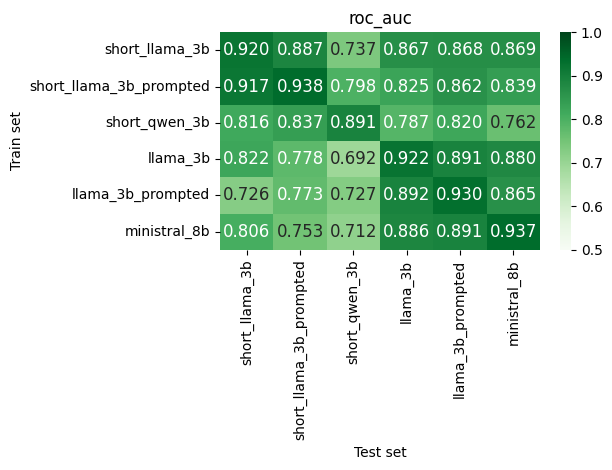

In [6]:
from probe_gen.standard_experiments.grid_experiments import plot_grid_experiment_lean

plot_grid_experiment_lean(probes_setup, test_dataset_names, "llama_3b", metric="roc_auc")